In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score,f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler, FunctionTransformer

from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier as GBC

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_path='/content/drive/MyDrive/Python/Monsoon Credit Tech/DS Test/DS Test/Training/'
X_df=pd.read_csv(train_path+'X_train.csv', index_col=0)
y_df=pd.read_csv(train_path+'y_train.csv',index_col=0)
data=X_df.join(y_df)
assert len(X_df)==len(data), 'Some Data is lost when joining'

#### Tackleing Null values

In [ ]:
def removing_null(df: pd.DataFrame,column_thres=30,row_nan_thres=4,thres_row_lost=85):
  '''
  df: The datframe containing all data points
  column_thres: Maximum percentage of nan's allowed in a particular coulumn.
                Default=30 i.e. if a column has more than 30% of nan's
                that column is removed
  row_nan_thres: Maximum allowed Nan's in a row. Default is 1. It is follwed by a check as well
  thres_row_lost: Minimum percentage of rows that should be kept. Default is 70.

  '''
  n=len(df) ## No. of Data Points
  compeleteness_df=pd.DataFrame(index=list(df.columns))
  percent_nan=[]

  for i in df.columns:
    per_nan=100*(df[i].isnull().sum()/n)
    percent_nan.append(per_nan)
  compeleteness_df['% of Nan']=percent_nan

  ## Filtering out the features that have more than 30% of Nan Values
  rel_features=compeleteness_df[compeleteness_df['% of Nan']<=column_thres].index
  df=df[rel_features]

  df_new=df[df.isnull().sum(axis=1) <=row_nan_thres]
  assert 100*(len(df_new)/n)> thres_row_lost, f"Atleast {thres_row_lost}% of the data isshould be retained, \
  Increase the 'row_nan_thres'"

  print(f'Percentage of Data Retained: ', 100*len(df_new)/n)
  return df_new,compeleteness_df

In [ ]:
data,_=removing_null(data)

Percentage of Data Retained:  86.03328290468987


In [ ]:
cat_var=['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8']
num_var=['N1', 'N2', 'N3', 'N4',
       'N5', 'N6', 'N7', 'N8', 'N9', 'N10', 'N10.1', 'N11', 'N12', 'N14',
       'N15', 'N16','N17', 'N18', 'N19', 'N20', 'N21', 'N22', 'N23', 'N24',
       'N33', 'N34', 'N35']

In [ ]:
## Converting datatype bool to category
for i in data.columns:
  if data[i].dtypes.name == 'bool':
    data[i] = data[i].astype(int)

for i in cat_var:
  data[i]=data[i].astype('category')

Helper Functions

In [ ]:
def outlier_and_interpolation(df, numerical_features=num_var):
  '''
  The function considers and data point as an outlier if it doesn't lie between [mean-3*std , mean+3*std]
  Those values are replaced by their respective column mean.

  df: DataFrame from which outliers are to be removed
  numerical_features: List of numerical features form which outliers are to be removed
  '''

  for i in numerical_features:
    mean=df[i].mean()
    std=df[i].std()

    upper_limit=mean+3*std
    lower_limit=mean-3*std

    df.loc[(df[i] <lower_limit) | (df[i] >upper_limit), i] = np.nan

  mean_dict=df.mean().to_dict()
  df.fillna(mean_dict,inplace=True)
  return df

## Removing the outliers
data=outlier_and_interpolation(data)

<ipython-input-25-08e9fd16a8f2>:19: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  mean_dict=df.mean().to_dict()


In [ ]:
def scaling_function(X):
  '''
  The functions scales the numerical features and outputs the transformed dataframe.
  It also returns the standardizing model
  '''
  nu_features=[i for i in X.columns if X[i].dtypes.name!='category']
  std=StandardScaler()
  X[nu_features]=std.fit_transform(X[nu_features])
  return X, std

In [ ]:
def compute_metrics(y_true, pred, pred_prob):
  '''
  caluclating arrcuray and roc_auc_score
  '''
  accuracy = accuracy_score(y_true, pred)
  auc_roc = roc_auc_score(y_true, pred_prob)

  return accuracy, auc_roc

In [ ]:
def train_models_and_evaluate(X, y):

  '''
  X: Input Features
  y: Target Variables

  1. The function takes input_features and targets. Splits them into test and train and scales them.
  2. It calculates the class weights as targets are unbalanced.
  3. It caluclates training accuray, training_roc_auc_score, testing_accuracy, testing_roc_auc_score for
     four commonly used models i.e. SVM, RandomForestClassifier, GradientBoostingClassifier and XGBoostClassifier.
  4. It returns a dataframe with training accuray, training_roc_auc_score, testing_accuracy, testing_roc_auc_score
    for all four models'
  '''

  cat_features=[]
  nu_features=[]
  for i in X.columns:
      if X[i].dtype.name=='category':
        cat_features.append(i)
      else:
        nu_features.append(i)


  # Split the data into train and test sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y)
  X_train, scaling_model=scaling_function(X_train)
  X_test[nu_features]=scaling_model.transform(X_test[nu_features])

  # Compute class weights
  class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

  # Train SVM model
  svm_model = svm.SVC(class_weight=dict(enumerate(class_weights)))
  svm_model.fit(X_train, y_train)
  svm_pred = svm_model.predict(X_test)
  svm_pred_train=svm_model.predict(X_train)
  svm_prob = svm_model.decision_function(X_test)
  svm_prob_train=svm_model.decision_function(X_train)

  svm_accuracy, svm_auc_roc = compute_metrics(y_test, svm_pred, svm_prob)
  svm_accuracy_train, svm_auc_roc_train = compute_metrics(y_train, svm_pred_train, svm_prob_train)

  # Train Random Forest Classifier model
  rf_model = RandomForestClassifier(max_samples=0.3,class_weight=dict(enumerate(class_weights)),max_features='log2')
  rf_model.fit(X_train, y_train)
  rf_pred = rf_model.predict(X_test)
  rf_prob = rf_model.predict_proba(X_test)[:, 1]
  rf_pred_train = rf_model.predict(X_train)
  rf_prob_train = rf_model.predict_proba(X_train)[:, 1]

  rf_accuracy, rf_auc_roc = compute_metrics(y_test, rf_pred, rf_prob)
  rf_accuracy_train, rf_auc_roc_train = compute_metrics(y_train, rf_pred_train, rf_prob_train)

  ## Training GBM Model ######################333
  sample_weights = np.zeros(len(y_train))
  sample_weights[y_train == 0] = class_weights[0]
  sample_weights[y_train == 1] = class_weights[1]

  model_g=GBC()
  model_g.fit(X_train, y_train, sample_weight=sample_weights)
  pred=model_g.predict(X_test)
  pred_prob=model_g.predict_proba(X_test)[:,1]

  pred_train=model_g.predict(X_train)
  pred_train_prob=model_g.predict_proba(X_train)[:,1]

  g_accuracy, g_auc_roc = compute_metrics(y_test, pred, pred_prob)
  g_accuracy_train, g_auc_roc_train = compute_metrics(y_train, pred_train, pred_train_prob)

  # Train XGBoost model
  dtrain = xgb.DMatrix(X_train, label=y_train,enable_categorical=True)
  dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

  xgb_params = {
      'objective': 'binary:logistic',
      'eval_metric': 'auc',
      'scale_pos_weight': sum(y_train == 0) / sum(y_train == 1)  # Adjust class imbalance
      }

  xgb_model = xgb.train(xgb_params, dtrain,)
  xgb_pred = xgb_model.predict(dtest)
  xgb_pred_train=xgb_model.predict(dtrain)

  xgb_accuracy, xgb_auc_roc = compute_metrics(y_test, (xgb_pred >= 0.5).astype(int), xgb_pred)
  xgb_accuracy_train, xgb_auc_roc_train = compute_metrics(y_train, (xgb_pred_train >= 0.5).astype(int), xgb_pred_train)


  # Create a dataframe to store the results
  results_df = pd.DataFrame({
      'Model': ['SVM', 'Random Forest','GBM' ,'XGBoost'],
      'Train_Accuracy': [svm_accuracy_train, rf_accuracy_train,g_accuracy_train ,xgb_accuracy_train],
      'Train_AUC-ROC': [svm_auc_roc_train, rf_auc_roc_train, g_auc_roc_train,xgb_auc_roc_train],
      'Test_Accuracy': [svm_accuracy, rf_accuracy, g_accuracy,xgb_accuracy],
      'Test_AUC-ROC': [svm_auc_roc, rf_auc_roc,g_auc_roc ,xgb_auc_roc]
  })

  return results_df


#### Checking Performance of these models with various methods of feature selection and feature engineering


1.   Using all features
2.   Using Chi square feature selection

1.   Feature selection using Mutual Information
2.   Using Principal Component Analysis







0    20101
1     8333
Name: Dependent_Variable, dtype: int64


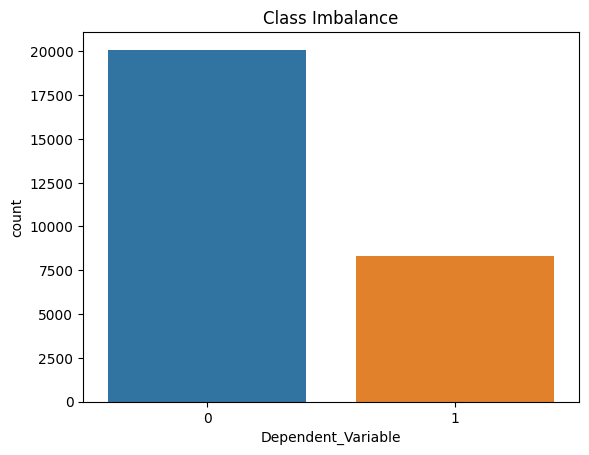

In [ ]:
import seaborn as sns
y=data['Dependent_Variable']
X=data.drop(['Dependent_Variable'],axis=1)

sns.countplot(x =y )
plt.title('Class Imbalance')
print(y.value_counts())

In [ ]:
### Using All features
results_all_features=train_models_and_evaluate(X, y)
results_all_features

,Model,Train_Accuracy,Train_AUC-ROC,Test_Accuracy,Test_AUC-ROC
0,SVM,0.656790,0.739172,0.634605,0.711779
1,Random Forest,0.884073,0.988413,0.729734,0.727093
2,GBM,0.684310,0.780016,0.655882,0.738375
3,XGBoost,0.704049,0.803467,0.656761,0.736527


In [ ]:
### Chi_Square feature selection max_features=10
feat_imp_chi=pd.DataFrame(index=X.columns)
from sklearn.feature_selection import chi2, SelectKBest
test = SelectKBest(score_func=chi2)
fit = test.fit(X, y)
feat_imp_chi['Chi scores']=fit.scores_
features_chi=list(feat_imp_chi.sort_values(by='Chi scores',ascending=False).index[:10])
y_chi=data['Dependent_Variable']
X_chi=data[features_chi]

results_chi=train_models_and_evaluate(X_chi, y_chi)
results_chi

,Model,Train_Accuracy,Train_AUC-ROC,Test_Accuracy,Test_AUC-ROC
0,SVM,0.631556,0.707020,0.618604,0.688720
1,Random Forest,0.878358,0.982703,0.720767,0.708529
2,GBM,0.667605,0.759141,0.635309,0.720653
3,XGBoost,0.678903,0.780784,0.631792,0.714854


In [ ]:
## using top 10 features using Mutual Information
from sklearn.feature_selection import mutual_info_classif as MIC
mutual_info=MIC(X,y)
df_featu_imp=pd.DataFrame(index=X.columns)
df_featu_imp['Info']=mutual_info
df_featu_imp.sort_values(by='Info',ascending=False,inplace=True)
features_mic=list(df_featu_imp.index[:10])
y_mic=data['Dependent_Variable']
X_mic=data[features_chi]

results_mic=train_models_and_evaluate(X_mic, y_mic)
results_mic

,Model,Train_Accuracy,Train_AUC-ROC,Test_Accuracy,Test_AUC-ROC
0,SVM,0.629753,0.703806,0.626165,0.701279
1,Random Forest,0.879852,0.983384,0.724987,0.722856
2,GBM,0.662021,0.757351,0.644276,0.735104
3,XGBoost,0.678463,0.778568,0.648497,0.726248


In [ ]:
from sklearn.decomposition import PCA
## Using PCA to get top 10 features
n_components=10
X_sc,_=scaling_function(X)
pca = PCA(n_components=n_components)
transformed_data = pca.fit_transform(X_sc)
X_pca = pd.DataFrame(data=transformed_data, columns=[f"PC{i+1}" for i in range(n_components)])
y_pca=data['Dependent_Variable']

results_pca=train_models_and_evaluate(X_pca, y_pca)
results_pca

,Model,Train_Accuracy,Train_AUC-ROC,Test_Accuracy,Test_AUC-ROC
0,SVM,0.670550,0.755301,0.643749,0.714330
1,Random Forest,0.868730,0.985212,0.723404,0.711424
2,GBM,0.665714,0.749950,0.645507,0.719164
3,XGBoost,0.689981,0.784002,0.638122,0.707234


#### It is seen that GradientBoostingClassifier with all features performs better. Since there no restraint imposed in training time, Fine-tuning the GradientBoostingClassifier with all the features would be best

In [ ]:
from sklearn.model_selection import GridSearchCV
def fine_tuning_GBM(X,y):
  # Compute class weights
  class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)

  #### Tuning ################################3
  sample_weights = np.zeros(len(y))
  sample_weights[y == 0] = class_weights[0]
  sample_weights[y == 1] = class_weights[1]

  model=GBC()
  param_grid = {
      #'learning_rate': [0.01, 0.1],
      'subsample': [0.6,0.8,1.0],
      'n_estimators':[100,130,150],

      }

  grid_cv=GridSearchCV(estimator=model, param_grid=param_grid, cv=5,scoring='roc_auc',verbose=False)
  grid_cv.fit(X,y,sample_weight=sample_weights)

  return grid_cv.best_score_,grid_cv.best_params_

In [ ]:
best_score, best_parameter=fine_tuning_GBM(X,y)

In [ ]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
    return None

In [ ]:
from sklearn.metrics import roc_curve

In [ ]:
### Training with Best Hyperparameter
def training_GBC(best_parameter=best_parameter):

  cat_features=[]
  nu_features=[]
  for i in X.columns:
      if X[i].dtype.name=='category':
        cat_features.append(i)
      else:
        nu_features.append(i)

  # Split the data into train and test sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y)
  X_train, scaling_model=scaling_function(X_train)
  X_test[nu_features]=scaling_model.transform(X_test[nu_features])

  # Compute class weights
  class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

  sample_weights = np.zeros(len(y_train))
  sample_weights[y_train == 0] = class_weights[0]
  sample_weights[y_train == 1] = class_weights[1]

  model_g=GBC(n_estimators=best_parameter['n_estimators'],
              subsample=best_parameter['subsample'])

  model_g.fit(X_train, y_train, sample_weight=sample_weights)
  pred=model_g.predict(X_test)
  pred_prob=model_g.predict_proba(X_test)[:,1]

  pred_train=model_g.predict(X_train)
  pred_train_prob=model_g.predict_proba(X_train)[:,1]
  g_accuracy, g_auc_roc = compute_metrics(y_test, pred, pred_prob)
  g_accuracy_train, g_auc_roc_train = compute_metrics(y_train, pred_train, pred_train_prob)

  fpr, tpr, thresholds = roc_curve(y_test, pred_prob)
  plot_roc_curve(fpr, tpr)


  print('Train AUC-ROC Score:', g_auc_roc_train)
  print('Train Accuracy: ',g_accuracy_train)
  print('Test AUC-ROC Score:', g_auc_roc)
  print('Test Accuracy: ' ,g_accuracy)

  return model_g,scaling_model


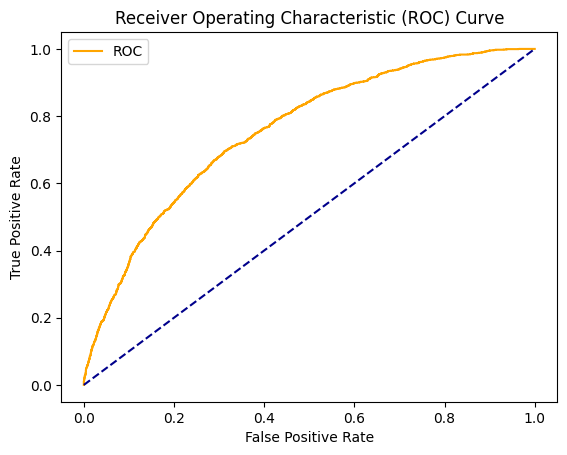

Train AUC-ROC Score: 0.7879653489881044
Train Accuracy:  0.6935859673803139
Test AUC-ROC Score: 0.7551556852808543
Test Accuracy:  0.6776859504132231


In [ ]:
tuned_model, scaling_model=training_GBC()

#### Predicting on Test cases

In [ ]:
import copy
def predicting(data,model=tuned_model, scaling_model=scaling_model, cat_var=cat_var):
  '''
  Function to make predictions on Test data.
  It returns the data in desired format.
  data: DataFrame on for which we want to predict
  model: final model
  '''
  X=copy.deepcopy(data)
  for i in cat_var:
    X[i]=X[i].astype('category')

  X=X[list(model.feature_names_in_)]
  X.dropna(inplace=True)
  cat_features=[]
  nu_features=[]
  for i in X.columns:
      if X[i].dtype.name=='category':
        cat_features.append(i)
      else:
        nu_features.append(i)

  X[nu_features]=scaling_model.transform(X[nu_features])
  X['Class_1_Probability']=model.predict_proba(X)[:,1]
  out_df=data.join(X['Class_1_Probability'], how='left')
  out_df=out_df[['Class_1_Probability']]

  return out_df

In [ ]:
test_path='drive/MyDrive/Python/Monsoon Credit Tech/DS Test/DS Test/Test/'
prediction_df=pd.read_csv(test_path+'X_test.csv',index_col=0)
out=predicting(prediction_df)

from google.colab import files
out.to_csv('Final Submission.csv')
files.download('Final Submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>